In [54]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request
import os
import torch

Re = 5e5 # Reynolds number
Sc = 2.0e-1 # Schmidt number
ic_index = 0 # Initial condition index

print(f"Target simulation:")
print(f"    Reynolds number: {Re:.0e}")
print(f"    Schmidt number: {Sc:.1f}")
print(f"    Initial condition: {ic_index}")

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported")

Target simulation:
    Reynolds number: 5e+05
    Schmidt number: 0.2
    Initial condition: 0
✓ Libraries imported


In [55]:
filename = f'shearflow_1d_profiles_Re{Re:.0e}_Sc{Sc:.1e}_ic{ic_index}.npz'

# Check if file exists locally
if not Path(filename).exists():
    print(f"📥 File not found locally: {filename}")
    print(f"   Attempting to download from GitHub repository...")
    
    # Construct GitHub raw URL
    github_base = "https://raw.githubusercontent.com/natrask/ENM5320-2026/main/NewMaterial/shearflow_project/"
    github_url = github_base + filename
    
    try:
        print(f"   URL: {github_url}")
        print(f"   Downloading... (this may take a minute for large files)")
        
        # Download the file
        urllib.request.urlretrieve(github_url, filename)
        
        file_size_mb = os.path.getsize(filename) / (1024**2)
        print(f"   ✓ Download complete! ({file_size_mb:.2f} MB)")
        print(f"   Saved to: {Path.cwd() / filename}")
        
    except urllib.error.HTTPError as e:
        print(f"   ❌ Download failed: {e}")
        print(f"\n   This file may not exist in the repository yet.")
        print(f"   Please run shearflow_preprocessing.ipynb to generate it,")
        print(f"   or choose different parameters (Re, Sc, ic_index).")
        raise FileNotFoundError(f"Could not find or download {filename}")
    except Exception as e:
        print(f"   ❌ Unexpected error: {e}")
        raise
else:
    print(f"✓ Found file locally: {filename}")


✓ Found file locally: shearflow_1d_profiles_Re5e+05_Sc2.0e-01_ic0.npz


In [56]:
data = np.load(filename)

for key in data.keys():
    if isinstance(data[key], np.ndarray):
        print(f"{key:20s}: shape={str(data[key].shape):20s} dtype={data[key].dtype}")
    else:
        print(f"{key:20s}: {data[key]}")


time                : shape=(200,)               dtype=float64
x                   : shape=(512,)               dtype=float32
tracer_mean         : shape=(200, 512)           dtype=float32
tracer_std          : shape=(200, 512)           dtype=float32
Re                  : shape=()                   dtype=float64
Sc                  : shape=()                   dtype=float64
ic_index            : shape=()                   dtype=int32
velocity_x_mean     : shape=(200, 512)           dtype=float32
velocity_x_std      : shape=(200, 512)           dtype=float32
velocity_y_mean     : shape=(200, 512)           dtype=float32
velocity_y_std      : shape=(200, 512)           dtype=float32
velocity_mag_mean   : shape=(200, 512)           dtype=float32
velocity_mag_std    : shape=(200, 512)           dtype=float32


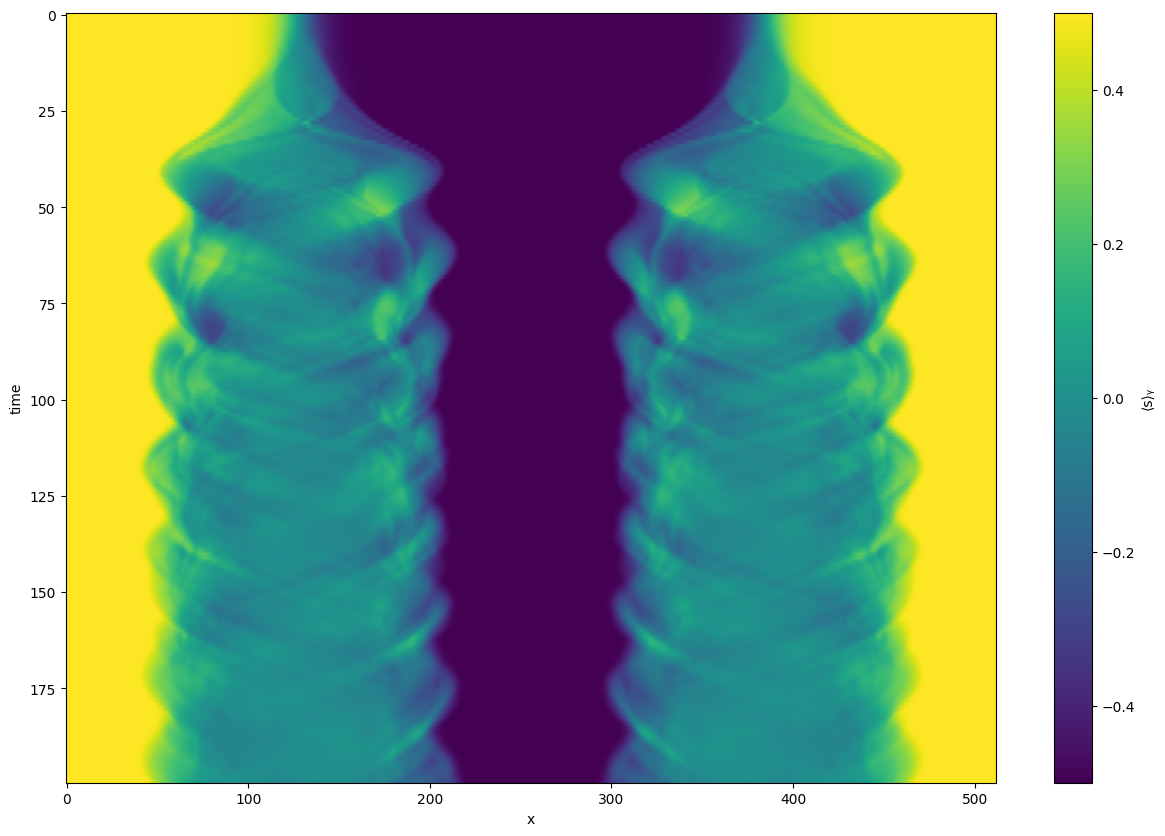

In [57]:
tracer_mean = data['tracer_mean']
plt.imshow(tracer_mean, aspect='auto')
plt.colorbar(label='⟨s⟩ᵧ')
plt.xlabel('x')
plt.ylabel('time')
plt.show()

In [87]:
def build_learnableStencil_periodic(N, coeffs, device='cpu'):
    """
    finite difference matrix associated with a machine learnable stencil `coeffs`
    """
    dx = 1./N

    # Build tridiagonal matrix
    upper_diag2 = coeffs[4] * torch.ones(N - 2, device=device)
    upper_diag1 = coeffs[3] * torch.ones(N - 1, device=device)
    main_diag = coeffs[2] * torch.ones(N, device=device)
    under_diag1 = coeffs[1] * torch.ones(N - 1, device=device)
    under_diag2 = coeffs[0] * torch.ones(N - 2, device=device)
    D_xx = (torch.diag(main_diag) + 
        torch.diag(upper_diag1, diagonal=1) + torch.diag(under_diag1, diagonal=-1) +
        torch.diag(upper_diag2, diagonal=2) + torch.diag(under_diag2, diagonal=-2))

    # Add periodic boundary conditions (corners)
    D_xx[0, -1] = coeffs[0]
    D_xx[-1, 0] = coeffs[-1]
    
    # upper_diag = coeffs[2] * torch.ones(N - 1, device=device)
    # main_diag = coeffs[1] * torch.ones(N, device=device)
    # under_diag = coeffs[0] * torch.ones(N - 1, device=device)
    # D_xx = torch.diag(main_diag) + torch.diag(upper_diag, diagonal=1) + torch.diag(under_diag, diagonal=-1)
    
    # # Add periodic boundary conditions (corners)
    # D_xx[0, -1] = coeffs[0]
    # D_xx[-1, 0] = coeffs[-1]
    
    return D_xx

# D_xx = build_learnableStencil_periodic(10, [0.2,.5,1.0,.5,0.2], device='cpu')
# print(D_xx.cpu().numpy())

In [104]:
device = 'cpu'
N = 512  # spatial points
M = 199  # number of time steps (200 snapshots means 199 transitions)

# Convert data to torch
tracer_tensor = torch.tensor(tracer_mean, dtype=torch.float32, device=device)
# Initialize learnable stencil coefficients
stencil_coeffs = torch.tensor([-0.1, -0.03, 0.0, 0.2, -0.08], requires_grad=True, device=device)
dt = data['time'][1] - data['time'][0]  # time step size

In [105]:
# Optimizer
optimizer = torch.optim.Adam([stencil_coeffs], lr=0.008)

# Training loop skeleton
num_epochs = 2000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Build stencil matrix
    D = build_learnableStencil_periodic(N, stencil_coeffs, device=device)
    A = torch.eye(N, device=device) - dt * D
    
    # Predict evolution
    predicted = torch.zeros_like(tracer_tensor)
    predicted[0] = tracer_tensor[0]
    
    for t in range(M):
        predicted[t+1] = torch.linalg.solve(A, predicted[t])
    
    # Compute loss
    loss = torch.mean((predicted - tracer_tensor)**2)
    
    # Backprop
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d}  Loss {loss.item():.4e}  Stencil {stencil_coeffs.data.tolist()}")

print(f"\nFinal stencil: {stencil_coeffs.data}")

Epoch    0  Loss 9.3785e-02  Stencil [-0.1080000028014183, -0.03799999877810478, -0.00800000037997961, 0.19200000166893005, -0.08799999952316284]
Epoch   50  Loss 4.5517e-02  Stencil [-0.05404815822839737, -0.07003570348024368, -0.07376772910356522, 0.16446083784103394, -0.020136648789048195]
Epoch  100  Loss 4.5147e-02  Stencil [-0.040538568049669266, -0.06912777572870255, -0.0850372165441513, 0.14800633490085602, -0.010817641392350197]
Epoch  150  Loss 4.4939e-02  Stencil [-0.027742117643356323, -0.06497928500175476, -0.09192518889904022, 0.13211284577846527, -0.0044655511155724525]
Epoch  200  Loss 4.4794e-02  Stencil [-0.016524599865078926, -0.05979006737470627, -0.0964311808347702, 0.11651754379272461, -0.0006512932595796883]
Epoch  250  Loss 4.4690e-02  Stencil [-0.0069785090163350105, -0.05412140488624573, -0.09897323697805405, 0.1017041876912117, 0.0015627023531123996]
Epoch  300  Loss 4.4614e-02  Stencil [0.0008271799306385219, -0.04840840399265289, -0.09991996735334396, 0.087

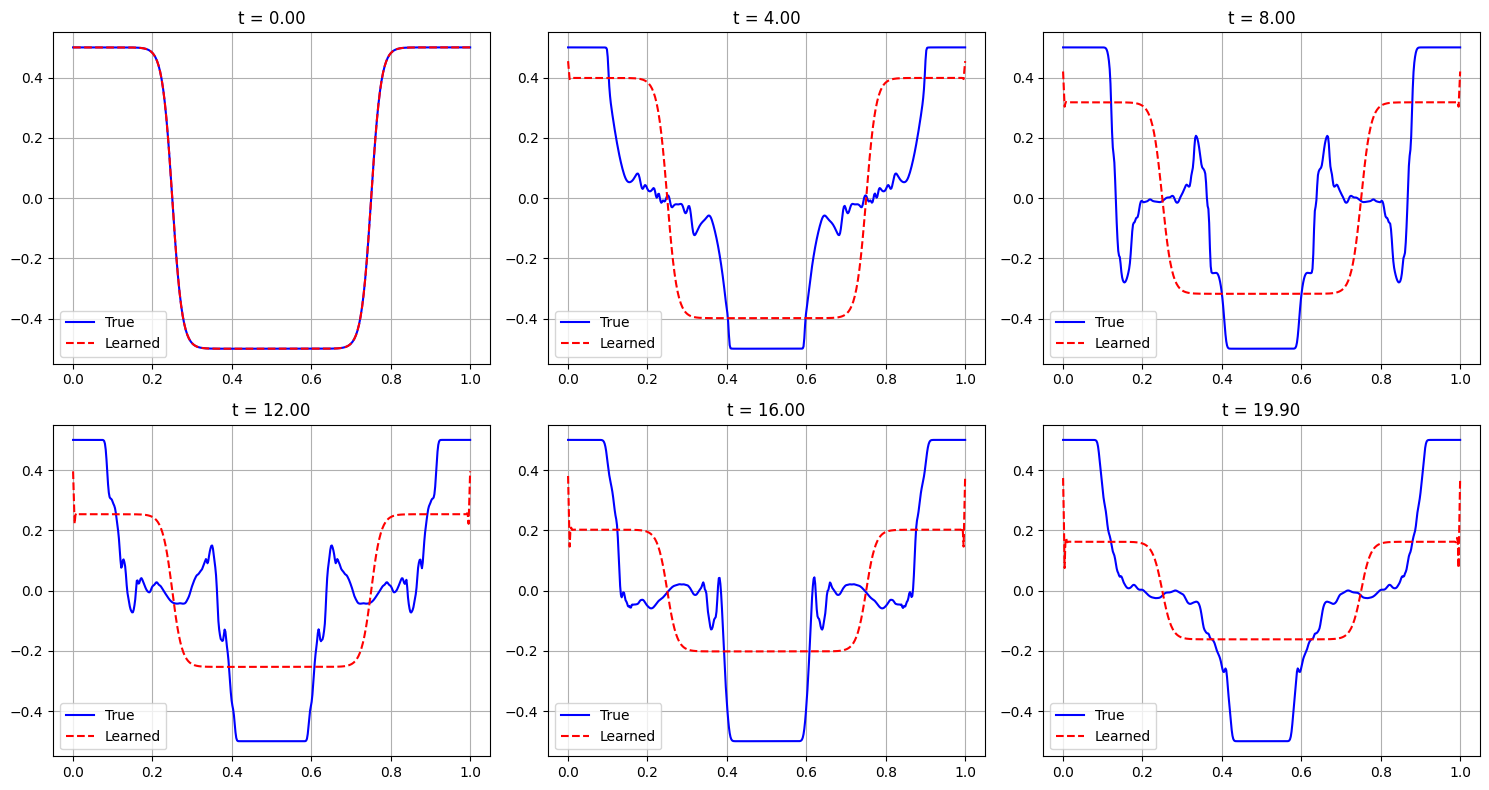

In [106]:
# Simulate with learned stencil
D_learned = build_learnableStencil_periodic(N, stencil_coeffs.data, device=device)
A_learned = torch.eye(N, device=device) - dt * D_learned

predicted_final = torch.zeros_like(tracer_tensor)
predicted_final[0] = tracer_tensor[0]

for t in range(M):
    predicted_final[t+1] = torch.linalg.solve(A_learned, predicted_final[t])

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
snapshot_times = [0, 40, 80, 120, 160, 199]

for idx, t_idx in enumerate(snapshot_times):
    ax = axes[idx//3, idx%3]
    ax.plot(data['x'], tracer_tensor[t_idx].cpu(), 'b-', label='True')
    ax.plot(data['x'], predicted_final[t_idx].cpu(), 'r--', label='Learned')
    ax.set_title(f"t = {data['time'][t_idx]:.2f}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()